# Python pour le Machine Learning : Projet Coronavirus + Modèle


## 1. Intro

Nous avons analysé les données d'un dataset sur le coronavirus pour identifier les variables les plus importantes. 

Puis, nous avons prétraité ce dataset dans le but de développer un modèle de machine learning. 

Et bien, avec tout ça, nous allons enfin développer un vrai modèle de machine learning en essayant de l'optimiser pour avoir les meilleures performances possibles. Pour cela, nous allons procéder de la façon suivante : 

- pour commencer, nous allons entraîner de nombreux modèles différents et nous retiendrons celui qui aura la meilleure performance. 
- Ensuite, nous tenterons d'améliorer la performance de ce modèle en optimisant ses hyperparamètres grâce à une série d'algorithmes comme GridSearchCV. 
- Enfin, je vous montrerai comment utiliser les courbes de précision et de recall afin de trouver le meilleur threshold, c'est-à-dire le meilleur seuil, pour notre modèle de machine learning.

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
url = 'https://raw.githubusercontent.com/MachineLearnia/Python-Machine-Learning/master/Dataset/dataset.csv'
data = pd.read_csv(url, index_col=0, encoding = "ISO-8859-1")

## 2. Pre- processing

In [4]:
df = data.copy()

## 3. Création des sous ensembles (EDA)

In [5]:
missing_rate = df.isna().sum()/df.shape[0]

In [6]:
blood_columns = list(df.columns[(missing_rate < 0.9) & (missing_rate >0.88)])
viral_columns = list(df.columns[(missing_rate < 0.80) & (missing_rate > 0.75)])

In [7]:
key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

In [8]:
df = df[key_columns + blood_columns + viral_columns]

## 4. TrainTest - Nettoyage - Encodage

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [11]:
trainset['SARS-Cov-2 exam result'].value_counts()

negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64

In [12]:
testset['SARS-Cov-2 exam result'].value_counts()

negative    1018
positive     111
Name: SARS-Cov-2 exam result, dtype: int64

In [13]:
def encodage(df):
    code = {'negative':0,
            'positive':1,
            'not_detected':0,
            'detected':1}
    
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)                
        
    return df

In [14]:
def feature_engineering(df):
    df['est malade'] = df[viral_columns].sum(axis=1) >= 1
    df = df.drop(viral_columns, axis=1)
    return df

In [15]:
def imputation(df):
    #df['is na'] = (df['Parainfluenza 3'].isna()) | (df['Leukocytes'].isna())
    #df = df.fillna(-999)
    df = df.dropna(axis=0)
    return  df

In [16]:
def preprocessing(df):
    
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)
    
    X = df.drop('SARS-Cov-2 exam result', axis=1)
    y = df['SARS-Cov-2 exam result']
    
    print(y.value_counts())
    
    return X, y

In [17]:
X_train, y_train = preprocessing(trainset)

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64


C:\Users\romeofr\AppData\Local\Temp\ipykernel_8928\556034734.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,col] = df[col].map(code)
C:\Users\romeofr\AppData\Local\Temp\ipykernel_8928\556034734.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,col] = df[col].map(code)
C:\Users\romeofr\AppData\Local\Temp\ipykernel_8928\556034734.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `

In [18]:
X_test, y_test = preprocessing(testset)

0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64


C:\Users\romeofr\AppData\Local\Temp\ipykernel_8928\556034734.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,col] = df[col].map(code)
C:\Users\romeofr\AppData\Local\Temp\ipykernel_8928\556034734.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,col] = df[col].map(code)
C:\Users\romeofr\AppData\Local\Temp\ipykernel_8928\556034734.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `

## 5. Procédure d'évaluation

In [19]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [20]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

## 6. Modélisation

Dasn la phase de Pre-Processing, nous avions déjà entraîné un modèle de machine learning. C'était donc un modèle de base qui nous avait permis de comprendre comment faire de la sélection de variables, comment imputer nos données avec un "dropna" ou avec un "fillna", tout cela dans le but d'améliorer au maximum la performance de ce modèle de base. 

À présent, nous allons tenter d'améliorer la performance du modèle lui-même, en nous basant sur les réglages effectués précédemment. 

Une approche possible est de commencer par créer une liste contenant plusieurs modèles de machine learning, par exemple 
- un Random Forest, 
- un Support Vector Machine, 
- un k-Nearest Neighbors, 

et d'évaluer chacun d'entre eux. De cette manière, nous pourrons identifier le meilleur modèle.

Allons-y, commençons par créer une liste de modèles qui inclura différents modèles de machine learning. Vous pouvez en inclure autant que vous le souhaitez. Personnellement, je choisirai 
- un algorithme de bagging, le RandomForestClassifier, 
- un algorithme de boosting, l'AdaBoostClassifier, ainsi qu'
- un algorithme Support Vector Machine. Pourquoi un algorithme Support Vector Machine ? Parce que ces algorithmes sont particulièrement efficaces sur des datasets de taille moyenne à petite. 
- Enfin, j'ajouterai également un algorithme de base, le k-Nearest Neighbors.

Mais au lieu de simplement intégrer ces algorithmes à notre liste, il va falloir que je les intègre à travers une "pipeline" qui reprendra tout ce que nous avons réalisé dans le Pre-processing. 

Donc je vais commencer par renommer cette "pipeline" "preprocessor" et je vais retirer le "RandomForestClassifier". 

Nous ajustons alors les opérations de transformation "PolynomialFeature" et "SelectKBest" dans ce "preprocessor". 

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [22]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), 
                             SelectKBest(f_classif, k=10))

À présent, cette "pipeline" "preprocessor", je vais l'ajouter en amont de tous les modèles que nous avons : "RandomForest", "AdaBoost", etc.

Je vais donc créer une nouvelle "pipeline", par exemple une "pipeline" "RandomForest" qui contiendra le "preprocessor" suivi de mon algorithme "RandomForest" avec, par exemple, un "random_state" égal à zéro. 

Ensuite, je vais procéder de la même manière pour "AdaBoost". Donc je vais créer un modèle "AdaBoost" qui est une "pipeline" comprenant d'abord le "preprocessor" suivi de "AdaBoostClassifier", avec également un "random_state" égal à zéro.

Puis, je vais créer un modèle "SVM" qui est une "pipeline" où l'on retrouvera le "preprocessor" suivi de "SVM". 

Mais attention, entre "preprocessor" et "SVM", il sera nécessaire d'ajouter une étape de normalisation. Pourquoi ? Car jusqu'à présent, nous n'avions pas réalisé de normalisation puisque les arbres de décision, les "RandomForestClassifier", et de la même manière les "AdaBoostClassifier", sont tous des modèles basés sur les arbres de décision qui n'ont pas besoin d'avoir des données normalisées. Cependant, ce n'est pas le cas du "Support Vector Machine" (SVM) ou du "K-Nearest Neighbors Classifier" ou de la grande majorité des modèles de machine learning que nous utilisons.

Ainsi, dans notre modèle SVM, nous ajouterons entre le "preprocessor" et le "SVM" une étape de "StandardScaler". Ce "StandardScaler" sera également ajouté avant le "SVM" dans notre "pipeline". Et nous aurons aussi un "random_state" égal à zéro.

Pour finir, nous ajouterons un "KNN" avec la "pipeline" comprenant "preprocessor", "StandardScaler" (car les SVM sont également sensibles à la normalisation des données) suivi du "KNeighborsClassifier". 

Pour le moment, vous l'aurez remarqué, nous laisserons nos modèles avec leurs paramètres par défaut.

In [23]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

Après avoir défini nos différents modèles, nous ajouterons notre liste de modèles qui contiendra le "RandomForest", "AdaBoostClassifier", le "Support Vector Machine" et le "K-Nearest Neighbors". 

In [24]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

Nous évaluerons ensuite tous ces modèles dans une boucle "for models in list of models" avec notre procédure d'évaluation. 

RandomForest
[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111

AdaBoost
[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111

SVM
[[92  3]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.67      0.38      0.48        16

    accuracy                           0.88       111
   macro avg       0.78      0.67      0.71  

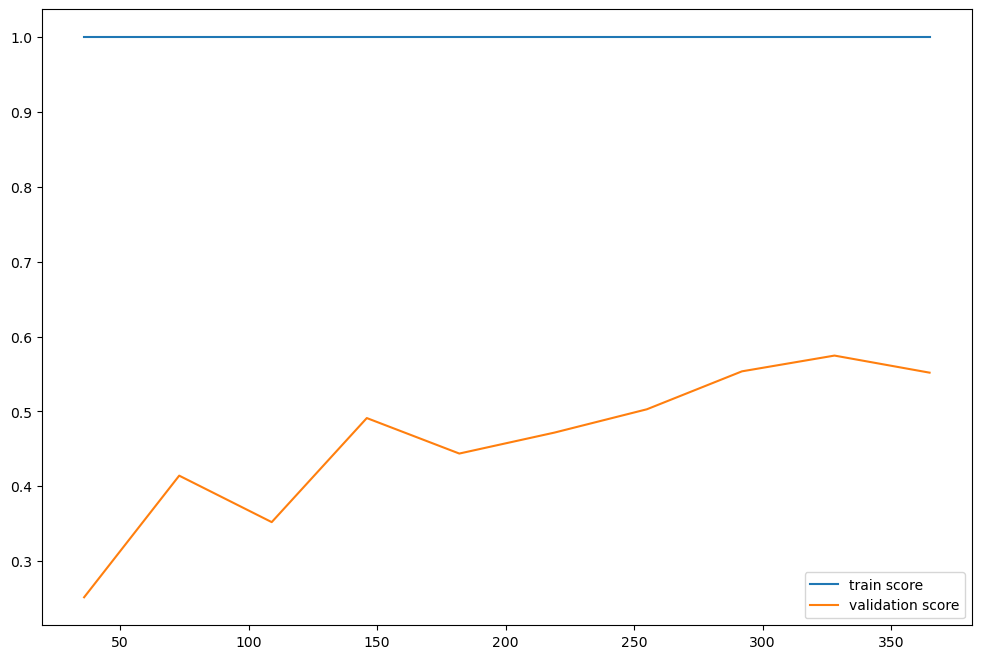

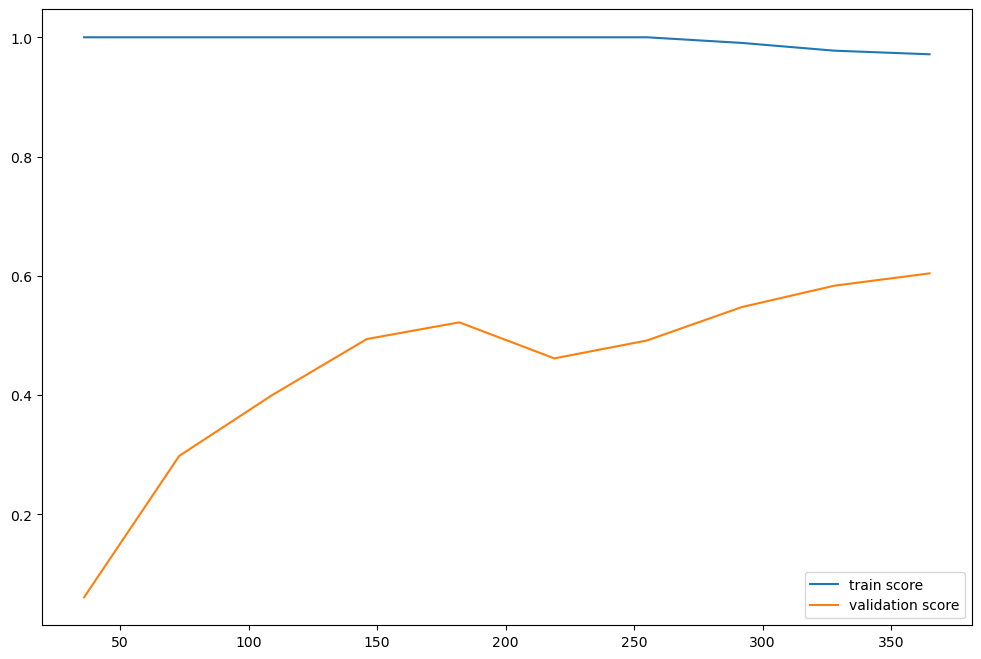

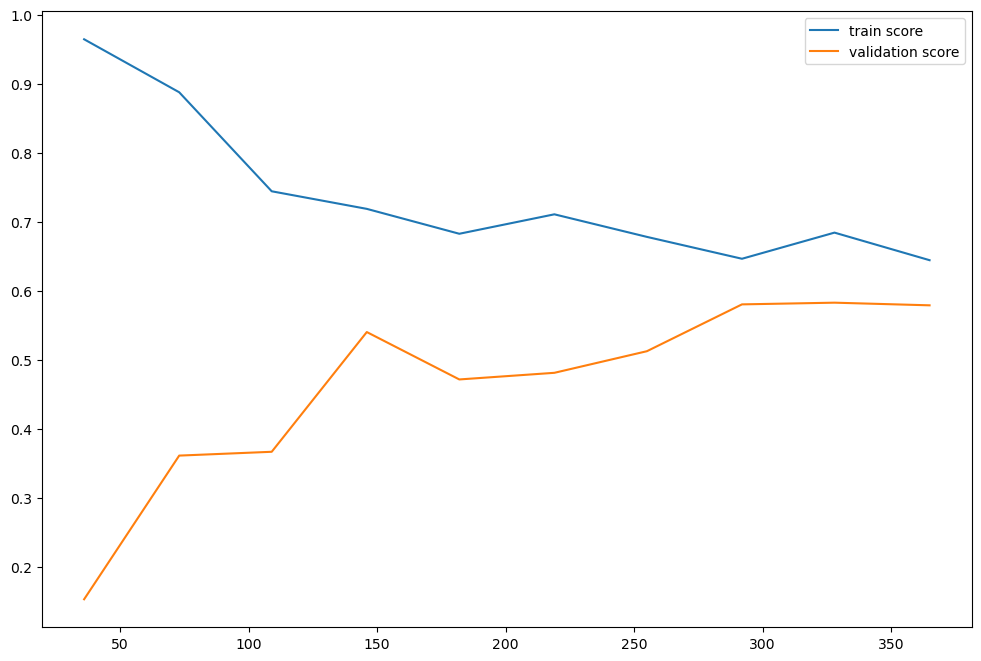

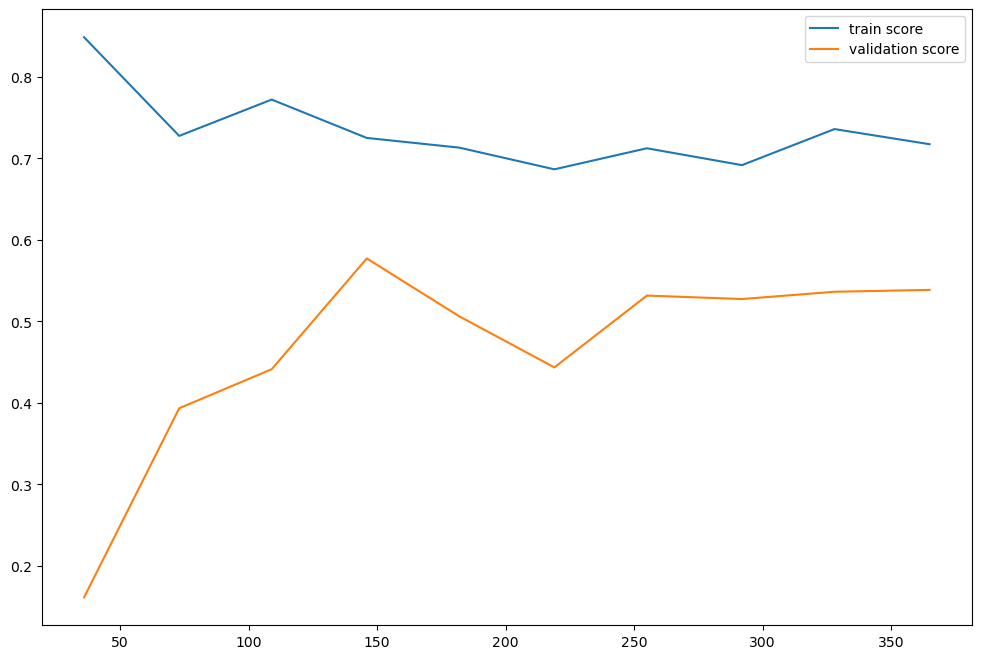

In [25]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

En exécutant le code, il est possible que nous recevions de nombreux messages d'avertissement, indiquant par exemple "feature 0 are constant". Ceci est dû à l'utilisation, dans notre pipeline, du "PolynomialFeatures" qui ajoute une colonne remplie de 1, soit une constante. 

Pour éviter ces messages, nous pouvons ajouter dans notre "preprocessor" l'option "include_bias=False".

Après exécution, nous remarquons que tous nos résultats sont affichés les uns au-dessus des autres, sans distinction claire. 

Une solution rapide pour résoudre ce problème est de convertir notre liste en dictionnaire, où par exemple "RandomForest" est associé à "RandomForest", et "AdaBoost" est associé à "AdaBoost". Ainsi, nous nommons nos différents modèles. 

Bien sûr, on pourrait analyser tout ça pendant très longtemps, mais pour aller vite, on va se concentrer sur le principal, qui est le rappel sur notre classe 1, c'est-à-dire les gens qui sont testés positifs. 

Si on veut être encore plus général, on va s'intéresser au score F1 de la classe 1 et on va tenter de prendre le meilleur F1 score pour la classe 1 parmi tous nos modèles. 

On a 
- un Random Forest avec 40% de F1 score, 
- un AdaBoost à 52%. Donc, AdaBoost est meilleur. 
- Support Vector Machine est à 48%, c'est mieux que Random Forest mais un peu moins bon qu'AdaBoost. 
- KNN est à 52% lui aussi.

En analysant un peu nos courbes d'apprentissage, 
- le Random Forest, on l'avait déjà analysé la dernière fois. 
- AdaBoost, on dirait qu'ils montrent un plus haut niveau de validation score que le Random Forest. 
- Ensuite, le Support Vector Machine, ça peut être très intéressant, car le Support Vector Machine est en train de nous indiquer qu'il n'est plus en overfitting. Son score sur le training a chuté, mais il se rapproche beaucoup du validation score. On ne peut pas parler d'overfitting dans cette situation, donc c'est intéressant. 
- Le Support Vector Machine peut être très bon. 
- Et KNN, lui aussi, semble atteindre de bons scores. Le training score chute, mais ce n'est pas grave. Ce qui est important, c'est d'avoir un écart réduit entre le training et la validation, car cela montre que le modèle a bien appris mais qu'il est capable de généraliser. Il n'a pas overfit. KNN, lui, pourrait être un bon choix, mais je vais le laisser de côté car ce n'est pas le plus adapté. KNN est un modèle basé sur les instances, c'est-à-dire les données qu'on lui fournit. 

Je préfère largement me concentrer sur un Support Vector Machine ou un AdaBoost, qui me semblent bien plus prometteurs.

### 7. Optimisation
Ce que l'on va faire, c'est qu'on va importer GridSearchCV depuis model_selection. 

In [26]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

C'est parti, on va commencer à optimiser un modèle. Par exemple, je vais essayer d'optimiser le modèle SVM. Mais vous, de votre côté, vous pouvez tenter d'optimiser AdaBoost. Ça peut être intéressant d'essayer d'optimiser AdaBoost de votre côté.

Lorsqu'on utilise GridSearchCV, il faut définir un dictionnaire d'hyperparamètres. 

Pour savoir quels hyperparamètres utiliser, j'aime bien imprimer tout mon pipeline, par exemple SVM. 

In [27]:
SVM

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest())])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])

On a d'abord l'étape de preprocessing qui s'appelle 'pipeline'. Dans cette étape, on n'a pas besoin d'y toucher pour le moment. 

On voit que le paramètre K est égal à 10 et le paramètre polynomial est égal à 2. Ce sont les hyperparamètres que l'on avait fixés dans l'ananlyse de Pre-processing. 

Ensuite, on a un StandardScaler, on n'a pas besoin d'y toucher. 

Après, on a notre Support Vector Classifier. Les hyperparamètres importants pour le Support Vector Machine sont le coefficient de pénalité C et éventuellement le gamma.

On va créer un dictionnaire hyper_params avec deux clés : gamma et C. 

Pour gamma, on va tester des valeurs, disons 1e-3 et 1e-4. Pour le coefficient C, on va prendre, disons, 1, 10, 100 et 1000. Ces sont des valeurs simples, des paliers sur une échelle logarithmique.

In [28]:
hyper_params = {'svc__gamma':[1e-3, 1e-4],
                'svc__C':[1, 10, 100, 1000]}

Maintenant qu'on a ça, il ne faut pas oublier de passer ce dictionnaire hyper_params dans notre GridSearchCV. 

On écrit "grid = GridSearchCV", dans lequel on passe notre modèle SVM, qui est une pipeline. 

Dans cette pipeline, on a beaucoup d'autres hyperparamètres. Rappelez-vous qu'il faut indiquer à quelle étape appartient cet hyperparamètre. Donc on écrit "SVC__gamma" pour prendre l'étape SVC suivi de gamma. On fait de même pour le coefficient C, donc "SVC__C". 

Dans GridSearchCV, on passe SVM, notre dictionnaire hyper_params et un scoring. On pourrait prendre le score F1 ou le rappel. Nous allons prendre le rappel, car c'était notre objectif pendant la phase d'exploration, c'est-à-dire le nombre de gens qui sont positifs au virus mais qu'on ne détecte pas comme étant positifs. Du coup, on laisse en liberté les personnes contaminées, ce qui est grave. 

On va donc tenter d'optimiser le rappel avec une cross-validation égale à 4.

In [29]:
grid = GridSearchCV(SVM, hyper_params, scoring='recall', cv=4)

On me demande parfois comment choisir le nombre de splits, que ce soit 3, 4 ou 5. Il y a certaines règles,sachez que c'est pas ce qui est le plus important, donc on peut prendre trois, quatre, cinq. Ce sont des valeurs assez standard qu'on retrouve très souvent et qui fonctionnent très bien. 

Donc maintenant qu'on a notre grid, eh bien il va falloir l'entraîner. Donc on fait "grid.fit(X_train, y_train)" et avec notre grille, maintenant, par exemple, on va afficher les meilleurs hyperparamètres. Donc on va faire "grid point's best params" qui est un des attributs de la classe GridSearchCV. 

In [30]:
grid.fit(X_train, y_train)

print(grid.best_params_)

{'svc__C': 1000, 'svc__gamma': 0.001}


Et une fois qu'on a affiché nos meilleurs hyperparamètres, pourquoi ne pas calculer un vecteur de prédictions aet comparer ce résultat avec les valeurs attendues dans "classification report" qu'on avait déjà utilisé dans la pahse de Pre-processing.

Donc on fait "y_test, y_pred" et faites bien attention parce que l'ordre a de l'importance. Il faut toujours passer y_test en premier sinon tous les calculs sont inversés dans les matrices de confusion.

In [31]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        95
           1       0.70      0.44      0.54        16

    accuracy                           0.89       111
   macro avg       0.81      0.70      0.74       111
weighted avg       0.88      0.89      0.88       111



Et si on exécute ce code, on voit qu'on obtient un coefficient c égal à 1000, un coefficient gamma égal à 0.001 et au niveau des scores, on obtient 0.44 et 0.54. Et que voit-on ? Eh bien, on voit qu'on a une amélioration par rapport à tout à l'heure où on avait 0.38 et 0.48 pour notre support vector machine. 

Donc c'est très cool, on a réussi à améliorer un peu la performance de notre modèle en ajustant ses hyperparamètres. 

Alors à présent, on pourrait passer ce modèle dans notre fonction d'évaluation

[[92  3]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        95
           1       0.70      0.44      0.54        16

    accuracy                           0.89       111
   macro avg       0.81      0.70      0.74       111
weighted avg       0.88      0.89      0.88       111



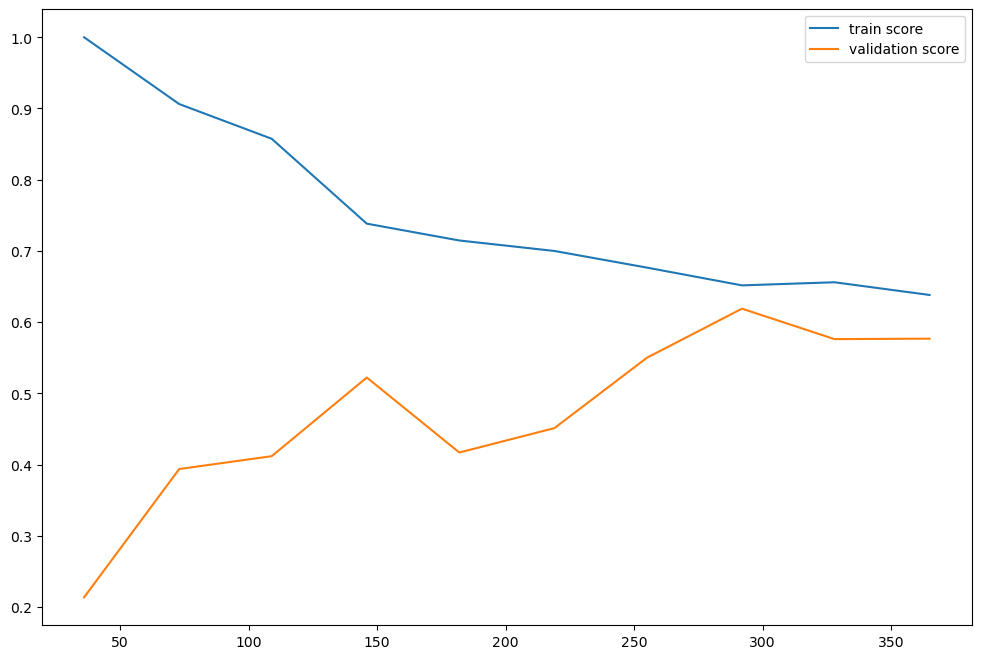

In [32]:
evaluation(grid.best_estimator_)

et on voit que la courbe du train score diminue en effet, mais la courbe du validation score augmente, et on commence à atteindre un palier où les deux se rejoignent. C'est très bien de constater ça parce que ça nous indique que le modèle n'est certainement pas en overfitting. Pourquoi ? Parce que son score sur le train set est le même que celui sur le validation set, à peu de choses près. 

Donc le modèle est capable de généraliser. 

"Il ne va pas être excellent sur le dataset mais mauvais dans la vraie vie", non, il a à peu près le même score, et ça c'est un bon signe. 

Maintenant, la question c'est : comment réussir à pousser le modèle encore plus loin ? Eh bien, on pourrait tenter de faire une GridSearchCV gigantesque sur tous les hyperparamètres de notre pipeline, en testant à chaque fois des centaines de configurations. Sauf que si vous faites ça, vous pouvez attendre longtemps. Je vous conseille de faire deux ou trois cafés. 

Non, mais blague à part, c'est impossible, un ou deux cafés ne suffira pas, votre ordinateur va tourner toute la journée. 

Donc pour tenter de faire des recherches lorsque vous avez un domaine très grand, je vous conseille d'utiliser RandomizedSearchCV à la place de GridSearchCV. Ce que va faire cet optimiseur, c'est chercher de façon aléatoire différentes combinaisons dans tout le domaine des hyperparamètres que vous allez définir. 

Donc, si vous avez par exemple un domaine dans lequel il y a 1000 configurations différentes, vous allez dire : "Testez-en dix au hasard", et ça, ça peut être très efficace. Si vous créez une boucle for dans laquelle le RandomizedSearchCV cherche plusieurs fois d'affilée dans un domaine que vous réduisez au fur et à mesure, mais c'est une technique avance qu'on n'utilsera pas ici.

Si on veut faire quelque chose d'assez basique, on va commencer par ajouter deux ou trois hyperparamètres dans notre dictionnaire. Donc on va rajouter quelque chose pour "PolynomialFeatures", dans lequel on va essayer de changer la règle de notre preprocessing. Donc on va faire, d'abord, il va falloir choisir l'étape : "pipeline__PolynomialFeatures__degree". Donc on va tester différents degrés, par exemple, le degré 2, 3 et 4, c'est déjà pas mal. 

Et un autre hyperparamètre qu'on pourrait tester, ça serait, par exemple, le célèbre "selectkbest". Donc, de la même manière, on va faire "pipeline__selectkbest__k" et pour la valeur de k, on peut aller chercher très loin. On peut faire, par exemple, un rang allant de 4 (donc quatre variables sélectionnées au minimum) jusqu'à 100. 

Pourquoi 4 ? Eh bien, parce que c'est une des valeurs qu'on avait testé dans l'analyse de Pre-condition. On a vu que le nombre minimum de variables viables, c'est 4. On va tester avec 4 et on va aller jusqu'à 100. 

Donc ça nous donne notre dictionnaire d'hyperparamètres dans lequel on a des centaines, voire des milliers de configurations possibles. 

In [33]:
hyper_params = {'svc__gamma':[1e-3, 1e-4, 0.0005],
                'svc__C':[1, 10, 100, 1000, 3000], 
               'pipeline__polynomialfeatures__degree':[2, 3],
               'pipeline__selectkbest__k': range(45, 60)}

Donc si on fait tout ça avec un GridSearchCV, on est mort, ça sert à rien, vous pouvez dire au revoir à votre machine et la retrouver dans une semaine. 

Donc, on va à la place utiliser un RandomizedSearchCV dans lequel on fait passer notre modèle SVM, on fait passer le dictionnaire des hyperparamètres, mais ce qu'on va faire passer également, c'est un nombre d'itérations. C'est-à-dire combien de fois est-ce que cet algorithme va devoir effectuer une recherche aléatoire parmi toutes nos combinaisons ? Donc combien de combinaisons on teste en réalité ? Et ce nombre, on peut le fixer à disons 40, par exemple. 

In [34]:
grid = RandomizedSearchCV(SVM, hyper_params, scoring='recall', cv=4,
                          n_iter=40)

Donc c'est pareil, on entraîne notre grille, on l'imprime et on voit qu'on obtient les mêmes hyperparamètres que tout à l'heure pour notre SVM. 

In [35]:
grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

{'svc__gamma': 0.001, 'svc__C': 1000, 'pipeline__selectkbest__k': 50, 'pipeline__polynomialfeatures__degree': 3}
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        95
           1       0.58      0.44      0.50        16

    accuracy                           0.87       111
   macro avg       0.75      0.69      0.71       111
weighted avg       0.86      0.87      0.87       111



Ensuite, selectkbest et on a 53 variables. Pour notre expansion polynomiale, on a trois degrés, et ça nous donne encore une fois de bons scores. 

Maintenant, bien sûr, on a seulement testé 40 configurations dans tout ce domaine, donc si vous voulez en tester plus, vous augmentez le nombre d'itérations. Et si vous voulez tester moins, vous diminuez. 

Et c'est pareil, si vous voulez faire des recherches plus avancées, c'est à vous de jouer avec la grid, avec les hyperparamètres. 

Voilà, on a donc vu comment améliorer nos modèles grâce à la recherche d'hyperparamètres, soit de façon exhaustive avec GridSearchCV, soit de façon aléatoire avec RandomizedSearchCV. 

## 8. Precision Recall Curve

Peu à peu, on améliore la performance de notre modèle. Il est très intéressant de finaliser la création de notre modèle en observant les courbes de précision et de rappel, et en définissant un seuil de décision. 

Nous allons utiliser la fonction "precision_recall_curve" du module "metrics". Cette fonction nous permet de visualiser la précision future et la sensibilité future de notre modèle en fonction d'un seuil de précision que nous définirons.

In [36]:
from sklearn.metrics import precision_recall_curve

En effet, la plupart des modèles que nous développons en machine learning, comme le modèle de support de vecteurs que nous sommes en train de développer, possèdent ce qu'on appelle une fonction de décision. Par exemple, dans le cas d'une régression logistique, cette fonction de décision nous permet de calculer la probabilité p(x), qui nous permet ensuite de faire une prédiction. 

Nous faisons cette prédiction en fonction d'un seuil. Par exemple, si notre seuil est égal à 0,5, alors si p(x) est supérieur à 0,5, la prédiction est que y est égal à 1, et sinon, y est égal à zéro. Nous pouvons déplacer ce seuil comme nous le souhaitons une fois que notre modèle a terminé son apprentissage.
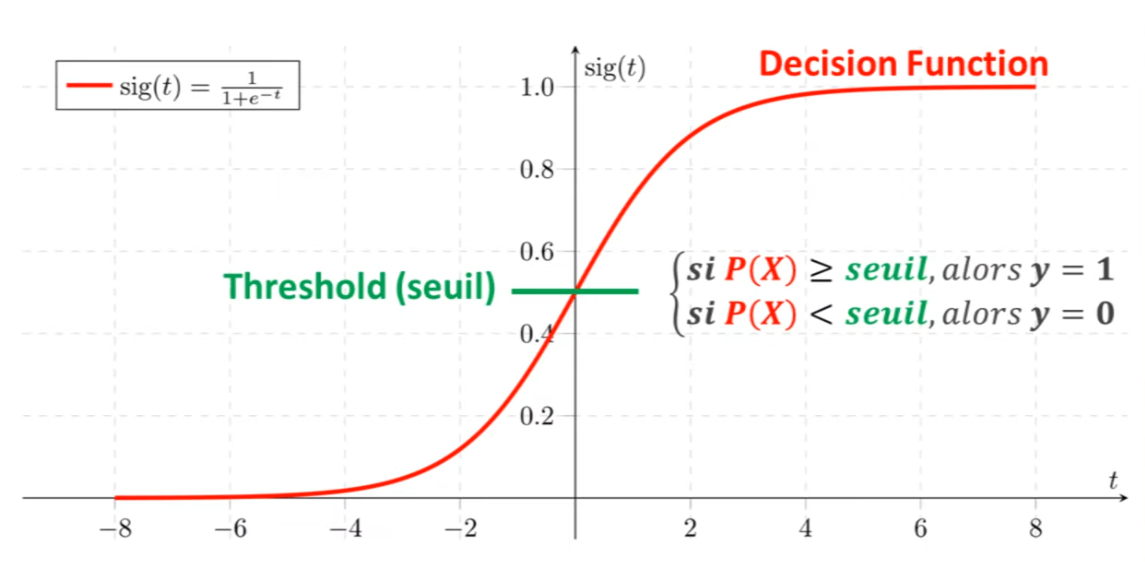

L'impact de ce choix peut être visualisé grâce à "precision_recall_curve". 

Nous allons utiliser cette fonction en passant comme arguments "y_test" et le résultat de la fonction de décision de "grid.best_estimator_" sur "X_test". Ceci nous retournera plusieurs choses : un tableau pour la précision, un tableau pour le rappel et un tableau pour différents seuils. 

In [37]:
precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))

Avec ces données, nous pourrons afficher un graphique en mettant le seuil en abscisse et la précision et le rappel en ordonnée.

Il y a cependant un détail technique à connaître : nous devons prendre la précision jusqu'à l'avant-dernier élément. Ce détail sera expliqué dans mes fiches résumées et je ferai des vidéos qui expliqueront cela plus en détail.

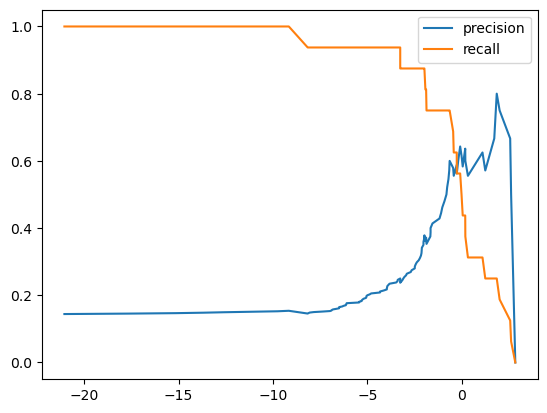

In [38]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

Sur le graphique, on peut observer que si nous choisissons un seuil de décision égal à -12, par exemple, notre rappel se rapproche de 100%. Cela signifie que tous ceux qui ont été testés positifs pour un virus auraient été correctement identifiés. 

Cependant, la précision serait compromise, car cela signifierait que même ceux qui ne sont pas affectés seraient envoyés à l'hôpital en soins intensifs, ce qui n'est pas souhaitable. 

Il est donc crucial de trouver un bon équilibre entre précision et rappel. En général, à mesure que la précision augmente, le rappel diminue. Il peut y avoir des erreurs ou des problèmes dans l'optimisation avec "RandomizedSearchCV". 

L'objectif est de définir le seuil de décision optimal pour notre support vector machine qui nous offre le meilleur rappel tout en conservant une bonne précision. 

Généralement, c'est le score F1 qui nous aide à trouver cet équilibre, mais selon nos besoins spécifiques, nous pourrions vouloir sacrifier un peu de précision pour obtenir un rappel supérieur. 

Donc, par exemple, vous pourrez essayer un seuil égal à -1, ce qui semblerait nous donner une précision pas trop mauvaise. 
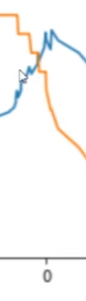

Évidemment, ce n'est pas le meilleur, mais avec un recall au-dessus des 0,6, presque pas loin des 0,7. 

Pour ça, nous allons créer une dernière fonction, une fonction qui va englober notre modèle. Ce sera notre véritable fonction de prédiction que nous allons nommer "modèle_final", qui prendra en paramètre notre modèle actuel ainsi qu'un seuil qui sera par défaut égal à 0. Cette fonction va retourner le résultat de "model.decision_function" sur les données x qu'on lui passe et on va dire que ça nous retourne "True" si en effet cela est supérieur au seuil, sinon ça nous retournera "False" si la valeur de la fonction est inférieure à ce seuil.

In [39]:
def model_final(model, X, threshold=0):
    return model.decision_function(X) > threshold

Donc, cette fonction, on la compile. 

Maintenant, on peut l'utiliser en disant que, par exemple, y_pred est égal au résultat des prédictions de "model_final" de notre "grid.best_estimator", ça sera notre modèle, X sera "X_test", et le seuil, bien, nous avons dit qu'il était égal à -1 par exemple. Nous allons essayer ça. 

In [40]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=-1)

À présent, pour terminer notre évaluation, nous allons évaluer y_pred avec le score F1. Donc, nous utiliserons "f1_score", qui est une des métriques disponibles dans Scikit-learn. 

In [41]:
from sklearn.metrics import recall_score

In [42]:
f1_score(y_test, y_pred)

0.5853658536585366

"f1_score" de "y_test" et "y_pred" et on voit qu'on a un score F1 de 0,54. Donc, c'est pas mal du tout.

Maintenant, nous allons voir ce que ça nous donne avec le recall. Celui-là, nous ne l'avions pas chargé, donc nous allons le charger avec "scikit_learn.metrics" pour "recall_score", et nous verrons ce que ça nous donne pour le recall.

In [43]:
recall_score(y_test, y_pred)

0.75

Ainsi, nous obtenons un recall de 69%. C'est vraiment pas mal, croyez-moi.

Donc, voilà, nous avons vu vraiment beaucoup de choses dans toute cette étude de cas. 

Ce que vous pouvez retenir, c'est que lorsque vous passez à la partie de modélisation, commencez par tester différents modèles dans un dictionnaire ou dans une liste de modèles, chacun ayant une caractéristique différente, une nature différente : un algorithme de bagging, un algorithme de boosting, un algorithme basé sur les instances, ou bien un algorithme de support vector machine, qui est généralement extrêmement efficace sur les petits datasets très complexes.

Évaluez tous ces modèles avec une procédure robuste, en utilisant toujours la même méthode, la même démarche, toujours les mêmes échantillons. Ainsi, vous avez une évaluation juste entre vos différents modèles. 

Ensuite, retenez les modèles qui vous donnent les meilleures performances, par exemple, support vector machine. Mais "AdaBoost" pourrait également vous donner de bons résultats. Je vous conseille de le chercher de votre côté si vous le souhaitez.

Ensuite, essayez d'optimiser ce modèle avec "GridSearchCV", puis un "RandomizedSearchCV". Cela va vous donner les meilleurs hyperparamètres. 

Et pour finir, dans le cas d'une classification binaire, c'est-à-dire déterminer si le patient est malade ou non, n'hésitez pas à afficher les courbes de précision et de recall pour définir vous-même le seuil de décision pour lequel vous allez dire qu'une personne est malade ou non. Car cela va vous permettre d'atteindre de meilleures performances que si vous dépendez uniquement des résultats qui vont vous être donnés par votre modèle de base.

Donc, pour cela, au lieu de simplement faire "votre_modèle.predict", utilisez "votre_modèle.decision_function" qui va vous donner la réponse du calcul interne du modèle pour chaque valeur du "X_test", mais pas la prédiction, juste la réponse au calcul. 

Et basé sur cette réponse, par exemple, si la réponse est de 0,4, vous vous dites : "Mon seuil de décision est égal à -1, 0,4 est supérieur à -1, donc à partir de là, je fais ma prédiction." Grâce à cela, vous pouvez vraiment améliorer la performance de votre modèle.

Voilà, nous avons vu beaucoup de choses ensemble, vraiment beaucoup de choses dans cette série. Bien sûr, nous pourrions continuer à tenter d'améliorer la performance du modèle. Une des choses que je n'ai pas faites, est de faire du oversampling, c'est-à-dire rajouter encore plus d'échantillons positifs c'est-à-dire rajouter encore plus d'échantillons positifs dans notre dataset, car nous avons clairement un dataset qui n'est pas équilibré. 

Il y a beaucoup plus de cas négatifs que de cas positifs. Pour cela, on peut utiliser une librairie qui s'appelle "SMOTE". Je ne l'ai pas fait ici notamment parce que ce n'est pas une technique qui est forcément bonne. C'est une technique qui peut sembler miraculeuse, mais elle est dangereuse, et je ne vous conseille pas forcément de l'utiliser dans tous les projets.